# same as 02b but getting precip values as outputs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

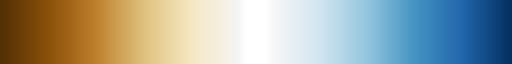

In [4]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [5]:
import os

In [6]:
model_list = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[1:]
# model_list2 = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[18:]
model_list#.extend(model_list2)

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-1',
 'EC-Earth3',
 'EC-Earth3-Veg-LR',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL',
 'obs',
 'rean']

In [7]:
len(model_list)

32

In [8]:
import climtas
from scipy import stats
# import seaborn as sns
import pandas as pd
from dateutil.relativedelta import relativedelta
import regionmask

def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def reorder(da):
    da['time'] = pd.date_range('1900-01-01', '2015-01-01', freq='1M')

    custom = da.sel(time=da.time.dt.month.isin([6,7,8,9,10,11,12,1,2,3,4,5]))
    # convert cftime to datetime
    datetimeindex = custom.indexes['time']#.to_datetimeindex() 
    # custom['time'] = pd.to_datetime(datetimeindex)
    
    # Add custom group by year functionality
    custom_year = custom['time'].dt.year
    
    # convert time type to pd.Timestamp
    time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    # time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    
    # Add year to Timestamp objects when month is before Jan. (relativedelta does not work from np.datetime64)
    time2 = [i + relativedelta(years=1) if i.month>=6 else i for i in time1] 
    custom['time'] = time2
    return custom

####

In [9]:
def extract_results_parallel(detrended_var, nino_anom, base_var):
    weights = np.cos(np.deg2rad(detrended_var.lat))
    weights.name = 'weights'
    # reorder the vars
    base_var = base_var.weighted(weights).mean(('lat', 'lon'))
    detrended_var = reorder(detrended_var).weighted(weights).mean(('lat', 'lon'))
    nino_anom = reorder(nino_anom)
    return detrended_var.to_numpy(), nino_anom.to_numpy(), base_var.to_numpy()


def calc_data_res_parallel(params):
    base_loc = '/scratch/ob22/as8561/data/'
    model = params[0]
    region = params[1]
    # get all the data
    precip = xr.open_dataset(base_loc + f'preproc/{model}/precip.nc').load().precip
    precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
    precip = precip.sortby(precip.lon)
    nino = xr.open_dataset(base_loc + f'preproc/{model}/nino.nc').load().nino
    if model=='obs':
        precip_base = xr.open_dataset(base_loc + f'preproc/{model}/base_precip.nc').load().precip
        precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
        precip_base = precip_base.sortby(precip_base.lon)
    elif model=='rean':
        precip_base = xr.open_dataset(base_loc + f'preproc/{model}/base_precip.nc').load().prate
        precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
        precip_base = precip_base.sortby(precip_base.lon)
    else: 
        precip_base = xr.open_dataset(base_loc + f'preproc/{model}/base_precip.nc').load().pr
        precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
        precip_base = precip_base.sortby(precip_base.lon)
    land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(precip, wrap_lon=False, drop=False)
    precip_land = precip.where(land_mask.isel(region=0))
    precip_base_land = precip_base.where(land_mask.isel(region=0))
    # mask for the ar6 land regions
    ar6_mask = regionmask.defined_regions.ar6.land.mask_3D(precip_land, wrap_lon=False, drop=False)
    out_precip, out_nino, out_base = extract_results_parallel(precip_land.where(ar6_mask.isel(region=region)), nino, precip_base_land.where(ar6_mask.isel(region=region)))
    return out_precip, out_nino, out_base

In [10]:
from multiprocessing import Pool
import itertools

In [11]:
region_list = regionmask.defined_regions.ar6.land.to_dataframe().index.to_numpy()

In [12]:
param_arr = [model_list, region_list]

In [13]:
param_list = list(itertools.product(*param_arr))

In [14]:
name_list = ['precip', 'nino', 'base']

In [15]:
len(name_list)

3

In [16]:
time = xr.open_dataset('/scratch/ob22/as8561/data/preproc/ACCESS-CM2/precip.nc').time.to_numpy()
time

array(['1900-01-16T12:00:00.000000000', '1900-02-15T00:00:00.000000000',
       '1900-03-16T12:00:00.000000000', ...,
       '2014-10-16T12:00:00.000000000', '2014-11-16T00:00:00.000000000',
       '2014-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [31]:
def convert_to_da(arr, name):
    return xr.DataArray(
        data = arr,
        dims = ["time", "region", "model"],
        coords = dict(
            time = (["time"], time),
            region = (["region"], region_list),
            model = (["model"], model_list),
        ),
        name = name
    )

def convert_to_da_base(arr, name):
    return xr.DataArray(
        data = arr,
        dims = ["month", "region", "model"],
        coords = dict(
            month = (["month"], np.arange(1, 13, 1)),
            region = (["region"], region_list),
            model = (["model"], model_list),
        ),
        name = name
    )

In [24]:
res_arr = []
with Pool() as pool:
    i = 0
    for res in pool.imap(calc_data_res_parallel, param_list):
        res_arr.append(res)
        print(f'completed {i+1}/{46*32}', end='\r')
        i += 1

In [32]:
# res_arr = np.array(res_arr)
da_arr = []
precip_arr = np.empty((1380, 1472))
nino_arr = np.empty((1380, 1472))
base_arr = np.empty((12, 1472))

for i in range(1472):
    precip_arr[:, i] = np.array(res_arr)[:, 0][i]
    nino_arr[:, i] = np.array(res_arr)[:, 1][i]
    base_arr[:, i] = np.array(res_arr)[:, 2][i]
    
da_precip = convert_to_da(np.reshape(precip_arr, (1380, 46, 32), order = 'F'), name_list[0])
da_nino = convert_to_da(np.reshape(nino_arr, (1380, 46, 32), order = 'F'), name_list[1])
da_base = convert_to_da_base(np.reshape(base_arr, (12, 46, 32), order = 'F'), name_list[2])

In [33]:
ds=xr.merge([da_precip, da_nino, da_base])

In [34]:
ds

<xarray.Dataset>
Dimensions:  (time: 1380, region: 46, model: 32, month: 12)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * model    (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, region, model) float64 9.079 -1.868 -0.09603 ... nan -13.48
    nino     (time, region, model) float64 -0.3419 0.8796 ... 0.9281 0.9281
    base     (month, region, model) float64 26.26 27.74 25.74 ... nan 34.17

In [36]:
ds.to_netcdf('./PhD/prelim_tasks/data/result/out.nc')

In [8]:
out = xr.open_dataset('./PhD/prelim_tasks/data/result/out.nc')
out

<xarray.Dataset>
Dimensions:  (time: 1380, region: 46, model: 32, month: 12)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, region, model) float64 ...
    nino     (time, region, model) float64 ...
    base     (month, region, model) float64 ...

In [9]:
# Nino events

In [10]:
import climtas
from scipy import stats
# import seaborn as sns
import pandas as pd

def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

In [11]:
naus = out.isel(region = -7, model = -2)
threshold = float(naus.nino.std())
print(threshold)

0.7658735583840788


In [70]:
nino_idx, nina_idx, neut_idx = get_event_indices(naus.nino, rolling_period=1, threshold=threshold, min_duration=1)

In [71]:
jja_nino = naus.nino[nino_idx].time.dt.month.isin([6,7,8])
jja_nina = naus.nino[nina_idx].time.dt.month.isin([6,7,8])
jja_neut = naus.nino[neut_idx].time.dt.month.isin([6,7,8])

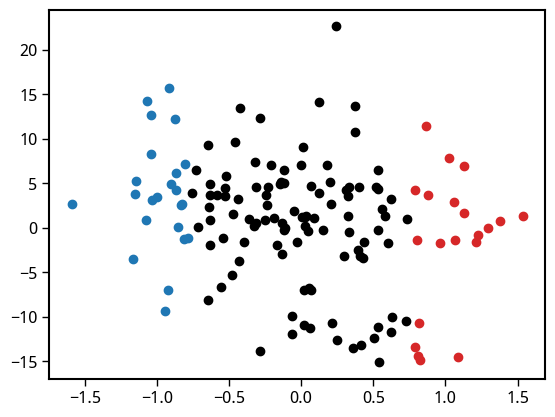

In [72]:
plt.scatter(naus.nino[nino_idx].sel(time = jja_nino).groupby('time.year').mean('time'), naus.precip[nino_idx].sel(time = jja_nino).groupby('time.year').mean('time'), color='tab:red')
plt.scatter(naus.nino[nina_idx].sel(time = jja_nina).groupby('time.year').mean('time'), naus.precip[nina_idx].sel(time = jja_nina).groupby('time.year').mean('time'), color='tab:blue')
plt.scatter(naus.nino[neut_idx].sel(time = jja_neut).groupby('time.year').mean('time'), naus.precip[neut_idx].sel(time = jja_neut).groupby('time.year').mean('time'), color='k')
# plt.ylim(-40, 40)

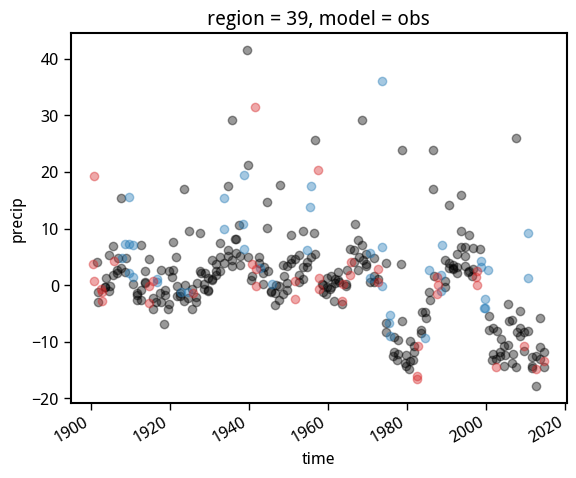

In [73]:
naus.precip[neut_idx].sel(time = jja_neut).plot.scatter(color='k', alpha = 0.4)
naus.precip[nina_idx].sel(time = jja_nina).plot.scatter(color='tab:blue', alpha = 0.4)
naus.precip[nino_idx].sel(time = jja_nino).plot.scatter(color='tab:red', alpha = 0.4)

In [75]:
djf_neut = out.isel(model = -2).nino[neut_idx].time.dt.month.isin([12,1,2])
mam_neut = out.isel(model = -2).nino[neut_idx].time.dt.month.isin([3,4,5])
jja_neut = out.isel(model = -2).nino[neut_idx].time.dt.month.isin([6,7,8])
son_neut = out.isel(model = -2).nino[neut_idx].time.dt.month.isin([9,10,11])

Text(0.5, 1.0, 'JJA')

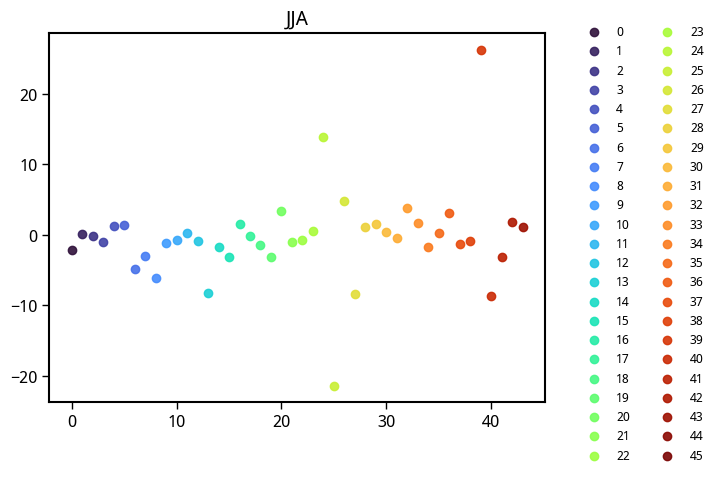

In [91]:
arr = np.arange(0, 46, 1)
norm = plt.Normalize()
colors = plt.cm.turbo(norm(arr))

for region in range(46):
    neut_val = out.isel(model = -2).precip[neut_idx].sel(time = jja_neut).isel(region = region).groupby('time.year').mean('time').median('year')
    # neut_val = out.isel(model = -2).precip[neut_idx].isel(region = region).groupby('time.year').mean('time').median('year')
    neut_clim = out.base.isel(model = -2, region = region).sel(month = [6,7,8]).mean('month')
    # neut_std = out.isel(model = -2).precip[neut_idx].sel(time = jja_neut).isel(region = region).groupby('time.year').mean('time').std('year')
    # neut_clim = out.base.isel(model = -2, region = region).mean('month')
    val = (neut_val/neut_clim)*100
    plt.scatter(region, val, alpha = 0.9, label = f'{region}', color = colors[region])

plt.legend(frameon = False, ncols = 2, fontsize = 9, bbox_to_anchor = [1.05, 1.05])
plt.title('JJA')

Text(0.5, 1.0, 'DJF')

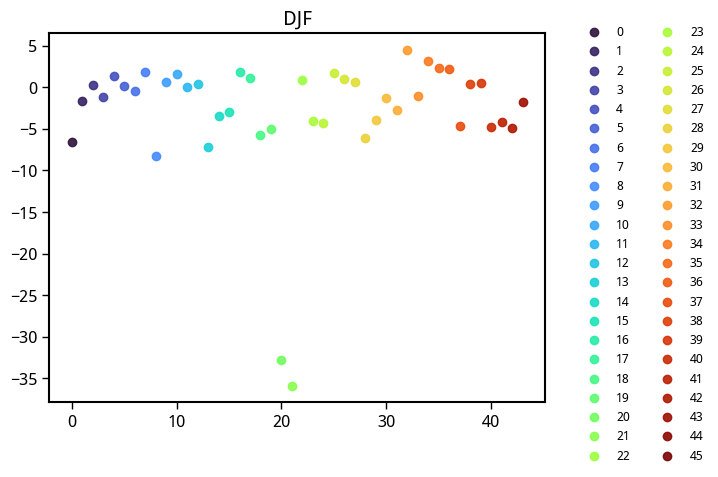

In [77]:
arr = np.arange(0, 46, 1)
norm = plt.Normalize()
colors = plt.cm.turbo(norm(arr))

for region in range(46):
    neut_val = out.isel(model = -2).precip[neut_idx].sel(time = djf_neut).isel(region = region).groupby('time.year').mean('time').median('year')
    # neut_val = out.isel(model = -2).precip[neut_idx].isel(region = region).groupby('time.year').mean('time').median('year')
    neut_clim = out.base.isel(model = -2, region = region).sel(month = [12,1,2]).mean('month')
    # neut_clim = out.base.isel(model = -2, region = region).mean('month')
    val = (neut_val/neut_clim)*100
    plt.scatter(region, val, alpha = 0.9, label = f'{region}', color = colors[region])

plt.legend(frameon = False, ncols = 2, fontsize = 9, bbox_to_anchor = [1.05, 1.05])
plt.title('DJF')

Text(0.5, 1.0, 'MAM')

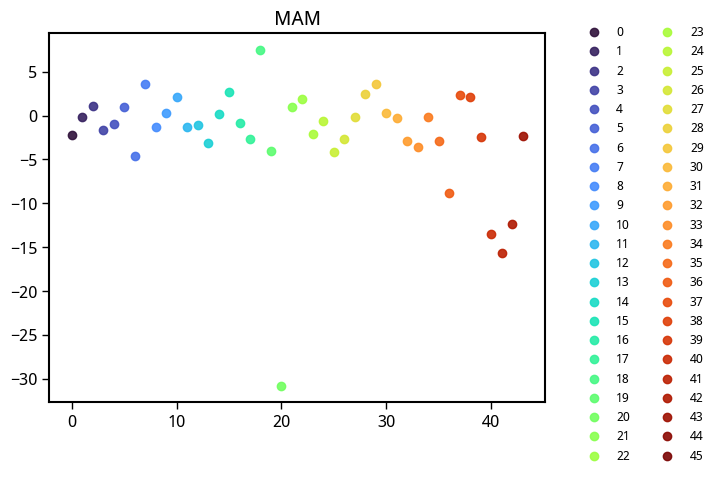

In [78]:
arr = np.arange(0, 46, 1)
norm = plt.Normalize()
colors = plt.cm.turbo(norm(arr))

for region in range(46):
    neut_val = out.isel(model = -2).precip[neut_idx].sel(time = mam_neut).isel(region = region).groupby('time.year').mean('time').median('year')
    # neut_val = out.isel(model = -2).precip[neut_idx].isel(region = region).groupby('time.year').mean('time').median('year')
    neut_clim = out.base.isel(model = -2, region = region).sel(month = [3,4,5]).mean('month')
    # neut_clim = out.base.isel(model = -2, region = region).mean('month')
    val = (neut_val/neut_clim)*100
    plt.scatter(region, val, alpha = 0.9, label = f'{region}', color = colors[region])

plt.legend(frameon = False, ncols = 2, fontsize = 9, bbox_to_anchor = [1.05, 1.05])
plt.title('MAM')

Text(0.5, 1.0, 'SON')

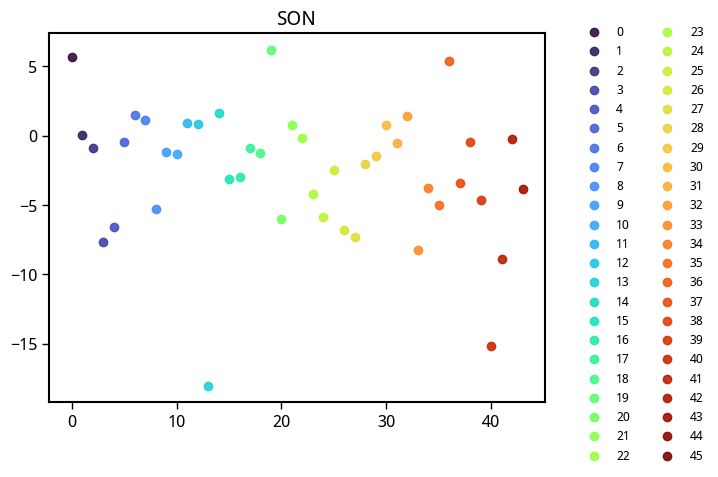

In [79]:
arr = np.arange(0, 46, 1)
norm = plt.Normalize()
colors = plt.cm.turbo(norm(arr))

for region in range(46):
    neut_val = out.isel(model = -2).precip[neut_idx].sel(time = son_neut).isel(region = region).groupby('time.year').mean('time').median('year')
    # neut_val = out.isel(model = -2).precip[neut_idx].isel(region = region).groupby('time.year').mean('time').median('year')
    neut_clim = out.base.isel(model = -2, region = region).sel(month = [9, 10, 11]).mean('month')
    # neut_clim = out.base.isel(model = -2, region = region).mean('month')
    val = (neut_val/neut_clim)*100
    plt.scatter(region, val, alpha = 0.9, label = f'{region}', color = colors[region])

plt.legend(frameon = False, ncols = 2, fontsize = 9, bbox_to_anchor = [1.05, 1.05])
plt.title('SON')

Text(0.5, 1.0, 'ANN')

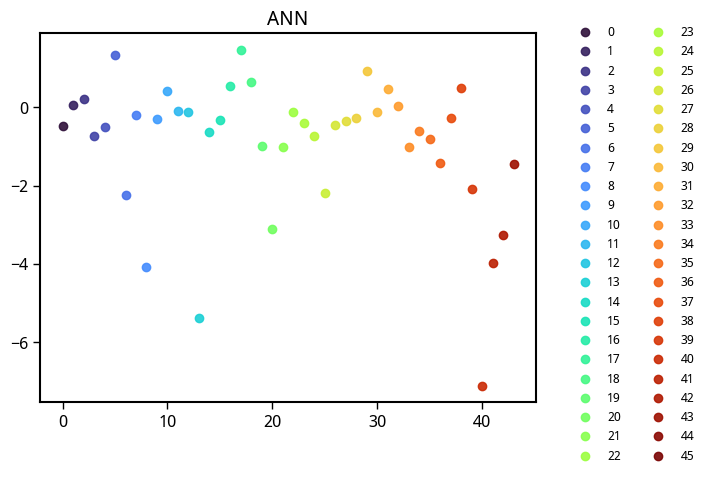

In [80]:
arr = np.arange(0, 46, 1)
norm = plt.Normalize()
colors = plt.cm.turbo(norm(arr))

for region in range(46):
    neut_val = out.isel(model = -2).precip[neut_idx].isel(region = region).groupby('time.year').mean('time').median('year')
    neut_clim = out.base.isel(model = -2, region = region).mean('month')
    val = (neut_val/neut_clim)*100
    plt.scatter(region, val, alpha = 0.9, label = f'{region}', color = colors[region])

plt.legend(frameon = False, ncols = 2, fontsize = 9, bbox_to_anchor = [1.05, 1.05])
plt.title('ANN')

In [81]:
naus_jja_clim = naus.base.sel(month = [6,7,8]).mean('month')
naus_jja_nino = ((naus.precip[nino_idx].sel(time = jja_nino).groupby('time.year').mean('time')/naus_jja_clim)*100)
naus_jja_nina = ((naus.precip[nina_idx].sel(time = jja_nina).groupby('time.year').mean('time')/naus_jja_clim)*100)
naus_jja_neut = ((naus.precip[neut_idx].sel(time = jja_neut).groupby('time.year').mean('time')/naus_jja_clim)*100)

In [82]:
get_corr(naus.nino.groupby('time.year').mean('time'), naus.precip.groupby('time.year').mean('time'), dim='year')

<xarray.DataArray ()>
array(-0.42181804)
Coordinates:
    region   int64 39
    model    <U3 'obs'

{'whiskers': [<matplotlib.lines.Line2D at 0x14711cb24b80>,
 'caps': [<matplotlib.lines.Line2D at 0x14711cb37100>,
 'boxes': [<matplotlib.lines.Line2D at 0x14711cb248e0>,
 'medians': [<matplotlib.lines.Line2D at 0x14711cb37640>,
 'fliers': [<matplotlib.lines.Line2D at 0x14711cb378e0>,
 'means': []}

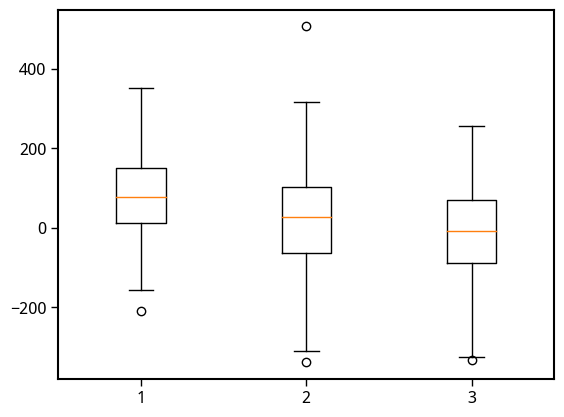

In [83]:
plt.boxplot([naus_jja_nina, naus_jja_neut, naus_jja_nino])
# plt.ylim(-50, 100)

In [88]:
out.isel(model=-2, region=-2).precip.values

array([nan, nan, nan, ..., nan, nan, nan])